# Williams Fractal Trading Simulator

## Description
This notebook is an experiment on the efficacy of the Williams Fractal trading strategy as described in the videos [Easy 1 Minute Scalping Trading Strategy | Simple But Effective](https://www.youtube.com/watch?v=juZlrecsIts) and [Simple But Effective 1 Minute Scalping Strategy Tested 100 Trades | EMA + Fractal Indicators](https://www.youtube.com/watch?v=0Q6iENmeUys) posted by Trade Pro.

I will be using an old BTCUSD dataset I extracted over a year ago for this simulation. 

#### This project is organized into the following sections:
1. Importing the relevant packages and prepping the dataset
2. Calculating trading indicators
3. Visualizing the dataset and indicators
4. Defining the trading strategy
5. Running a trading simulation loop and assessing the results
6. Final Word and refactoring ideas

## Import packages and prep dataset

In [16]:
import numpy as np
import pandas as pd
import mplfinance
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
import zipfile
import os
import shutil

In [17]:
# unzip BTCUSD data
if os.path.exists('./data'):
    shutil.rmtree('./data')
with zipfile.ZipFile('data.zip' , 'r') as zip_ref:
    zip_ref.extractall(".")
if os.path.exists('./__MACOSX'):
    shutil.rmtree('./__MACOSX')

In [18]:
# Create base dataframe
one_minute_df = pd.concat([
#     pd.read_csv("data/BTCUSD/2020/2-2020.csv"),
#     pd.read_csv("data/BTCUSD/2020/3-2020.csv"),
#     pd.read_csv("data/BTCUSD/2020/4-2020.csv"),
#     pd.read_csv("data/BTCUSD/2020/5-2020.csv"),
#     pd.read_csv("data/BTCUSD/2020/6-2020.csv"),
#     pd.read_csv("data/BTCUSD/2020/7-2020.csv"),
#     pd.read_csv("data/BTCUSD/2020/8-2020.csv"),
#     pd.read_csv("data/BTCUSD/2020/9-2020.csv"),
#     pd.read_csv("data/BTCUSD/2020/10-2020.csv"),
#     pd.read_csv("data/BTCUSD/2020/11-2020.csv"),
#     pd.read_csv("data/BTCUSD/2020/12-2020.csv"),
#     pd.read_csv("data/BTCUSD/2021/1-2021.csv"),
#     pd.read_csv("data/BTCUSD/2021/2-2021.csv"),
#     pd.read_csv("data/BTCUSD/2021/3-2021.csv"),
#     pd.read_csv("data/BTCUSD/2021/4-2021.csv"),
#     pd.read_csv("data/BTCUSD/2021/5-2021.csv"),
#     pd.read_csv("data/BTCUSD/2021/6-2021.csv"),
#     pd.read_csv("data/BTCUSD/2021/7-2021.csv"),
#     pd.read_csv("data/BTCUSD/2021/8-2021.csv"),
#     pd.read_csv("data/BTCUSD/2021/9-2021.csv"),
#     pd.read_csv("data/BTCUSD/2021/10-2021.csv"),
#     pd.read_csv("data/BTCUSD/2021/11-2021.csv"),
#     pd.read_csv("data/BTCUSD/2021/12-2021.csv"),
#     pd.read_csv("data/BTCUSD/2022/1-2022.csv"),
#     pd.read_csv("data/BTCUSD/2022/2-2022.csv"),
#     pd.read_csv("data/BTCUSD/2022/3-2022.csv"),
#     pd.read_csv("data/BTCUSD/2022/4-2022.csv"),
    pd.read_csv("data/BTCUSD/2022/5-2022.csv"),
    pd.read_csv("data/BTCUSD/2022/6-2022.csv"),
    pd.read_csv("data/BTCUSD/2022/7-2022.csv"),
    pd.read_csv("data/BTCUSD/2022/8-2022.csv")
])
cols = one_minute_df.columns.values
arr = one_minute_df.to_numpy()
one_minute_df = pd.DataFrame(arr, columns=cols)

one_minute_df

,ticker,datetime,open,high,low,close
0,BTCUSD,2022-05-01 00:01:00,38275.0,38277.0,38235.0,38267.0
1,BTCUSD,2022-05-01 00:02:00,38266.0,38266.0,38214.0,38214.0
2,BTCUSD,2022-05-01 00:03:00,38210.0,38263.0,38210.0,38245.0
3,BTCUSD,2022-05-01 00:04:00,38244.0,38244.0,38196.0,38199.0
4,BTCUSD,2022-05-01 00:05:00,38203.0,38243.0,38202.0,38202.0
...,...,...,...,...,...,...
136781,BTCUSD,2022-08-03 23:56:00,23251.0,23257.0,23251.0,23253.0
136782,BTCUSD,2022-08-03 23:57:00,23252.0,23252.0,23235.0,23251.0
136783,BTCUSD,2022-08-03 23:58:00,23248.0,23248.0,23241.0,23248.0
136784,BTCUSD,2022-08-03 23:59:00,23250.0,23262.0,23249.0,23261.0


## Calculate Indicators

### EMAs

Exponential Moving Averages (or EMAs) are lagging indicators that give a sense of the overall trend of the price action. Typically, several are used together, and/or in conjunction with other indicators to define a strategy. For the strategy I'm implementing, I'll need the 20 EMA, 50 EMA, and 100 EMA.

In [19]:
# emas
twenty_ema = one_minute_df.close.ewm(span=20, adjust=False).mean()
fifty_ema = one_minute_df.close.ewm(span=50, adjust=False).mean()
one_hundred_ema = one_minute_df.close.ewm(span=100, adjust=False).mean()

one_minute_df['twenty_ema'] = twenty_ema
one_minute_df['fifty_ema'] = fifty_ema
one_minute_df['one_hundred_ema'] = one_hundred_ema

### A note on Williams Fractals

The Williams Fractal indicator as defined by [Investopedia](https://www.investopedia.com/terms/f/fractal.asp) is a five candle reversal pattern where the high/low of the middle candle in question is the local extrema of its neighbors. Because we must wait for the following two candles to close, this indicator is considered a lagging indicator.

A bullish fractal occurs when the candle's low is the local minimum of its neighbors lows.
A bearish fractal occurs when the candle's high is the local maximum of its neighbors highs.

A red up arrow marks the location of a bearish fractal, while a green down arrow marks the location of a bullish fractal.
Arrows are drawn above or below the middle bar, even though the pattern requires five bars. 

If someone were to trade fractal signals, their entrypoint would have to be the open price of the third bar after the arrow.

Some sources are stricter on their definition of a Williams Fractal, claiming that the preceding candles for a bullish fractal must both be red, and the following candles both be green. The opposite is the case for bearish fractals. I won't use this strict definition in my experiment.

In [20]:
def mark_fractals(signal):
    bull = []
    bear = []
    
    for i in range(len(signal)):
        bull.append(np.nan)
        bear.append(np.nan)
    
    for i in range(5, len(signal)):
        minimum = signal.low[i - 3]
        if minimum < signal.low[i - 5] and minimum < signal.low[i - 4] and minimum < signal.low[i - 2] and minimum < signal.low[i - 1]:  
            bull[i - 3] = minimum
        
        maximum = signal.high[i - 3]
        if maximum > signal.high[i - 5] and maximum > signal.high[i - 4] and maximum > signal.high[i - 2] and maximum > signal.high[i - 1]:  
            bear[i - 3] = maximum
            
    return (bull, bear)

fractal = mark_fractals(one_minute_df)
one_minute_df['bull'] = fractal[0]
one_minute_df['bear'] = fractal[1]


In [21]:
one_minute_df

,ticker,datetime,open,high,low,close,twenty_ema,fifty_ema,one_hundred_ema,bull,bear
0,BTCUSD,2022-05-01 00:01:00,38275.0,38277.0,38235.0,38267.0,38267.000000,38267.000000,38267.000000,NaN,NaN
1,BTCUSD,2022-05-01 00:02:00,38266.0,38266.0,38214.0,38214.0,38261.952381,38264.921569,38265.950495,NaN,NaN
2,BTCUSD,2022-05-01 00:03:00,38210.0,38263.0,38210.0,38245.0,38260.337868,38264.140331,38265.535634,NaN,NaN
3,BTCUSD,2022-05-01 00:04:00,38244.0,38244.0,38196.0,38199.0,38254.496167,38261.585808,38264.218096,NaN,NaN
4,BTCUSD,2022-05-01 00:05:00,38203.0,38243.0,38202.0,38202.0,38249.496532,38259.249110,38262.986055,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
136781,BTCUSD,2022-08-03 23:56:00,23251.0,23257.0,23251.0,23253.0,23273.041554,23282.199578,23302.470010,NaN,NaN
136782,BTCUSD,2022-08-03 23:57:00,23252.0,23252.0,23235.0,23251.0,23270.942358,23280.976065,23301.450802,23235.0,NaN
136783,BTCUSD,2022-08-03 23:58:00,23248.0,23248.0,23241.0,23248.0,23268.757371,23279.682886,23300.392370,NaN,NaN
136784,BTCUSD,2022-08-03 23:59:00,23250.0,23262.0,23249.0,23261.0,23268.018574,23278.950224,23299.612323,NaN,NaN


## Visualize the dataset and indicators

Since the data files contain data for entire months of one-minute price action at a time, it's impractical to view the entire dataset all at once. The following variables configure a small viewing window on the dataset to give you a sense of what the indicators and price action look like in action.

#### The variables:
- quarter_day defines which six hour period you wish to start on
- window defines how many consecutive six hour periods you wish to view at once
- start and end are the actual row indices of the dataset the visuals will pull from

In [22]:
# variables for an easy viewing window on the dataset
quarter_day = 30 # 14
window = 1
start = (quarter_day - 1) * 360
end = start + (360 * window)

In [23]:
fig = go.Figure(
    data=[
        go.Candlestick(
            x=one_minute_df.datetime[start:end],
            open=one_minute_df.open[start:end], 
            high=one_minute_df.high[start:end],
            low=one_minute_df.low[start:end], 
            close=one_minute_df.close[start:end],
            name='Price Action'
        )
    ],
)

fig.add_scatter(
    x=one_minute_df.datetime[start:end], 
    y=one_minute_df.bull[start:end], 
    mode='markers', 
    marker=dict(
        symbol='triangle-down',
        color='green', 
        size=10, 
    ),
    name='Bull Marker'
)
fig.add_scatter(
    x=one_minute_df.datetime[start:end], 
    y=one_minute_df.bear[start:end], 
    mode='markers', 
    marker=dict(
        symbol='triangle-up',
        color='red', 
        size=10, 
    ),
    name='Bear Marker'
)

fig.add_scatter(
    x=one_minute_df.datetime[start:end], 
    y=one_minute_df.twenty_ema[start:end],
    mode='lines',
    name='20 EMA'
)
fig.add_scatter(
    x=one_minute_df.datetime[start:end], 
    y=one_minute_df.fifty_ema[start:end],
    mode='lines',
    name='50 EMA'
)
fig.add_scatter(
    x=one_minute_df.datetime[start:end], 
    y=one_minute_df.one_hundred_ema[start:end],
    mode='lines',
    name='100 EMA'
)


fig.update_layout(
    xaxis_rangeslider_visible=False,
    autosize=True,
    minreducedwidth=250,
    minreducedheight=250,
    height=750,
    title=dict(
        text="BTCUSD", 
        font=dict(size=25), 
        automargin=False, 
        yref='paper',
    ),
    title_x=.5,
    yaxis=dict(
        title_text="Price",
        titlefont=dict(size=20),
    ),
    xaxis=dict(
        title_text='Timestamp',
        titlefont=dict(size=20),
    )
)
config = {'staticPlot': True}
fig.show(config=config)

## Trading Strategy

The trading strategy follows these rules:

1. If the 20 EMA > 50 EMA > 100 EMA and the price (low) dips below the 20 EMA and a bullish fractal appears between the 20 and 50 EMAs: place a trade on the close of the triggering candle (or open of the following candle). The triggering candle will be the last of the 5 candles that defined the Williams Fractal. The stop loss will be the value of the 50 EMA at that candle, and the take profit is set with however much risk you want to take (typically 1.5:1 or 2:1).
2. If the first fractal doesn't appear until price action has moved below the 50 EMA, use the 100 EMA as your stop loss instead.
3. The rules for short positions are just the mirror of the first two rules.

## Trade Simulation

### Config Variables
The following variables are used to configure a partial simulation of live trading on the dataset. 
- A starting_balance is provided.
- The buffer_multiplier is the ratio of actual to effective account balance. Basically, because we're trading on the one minute timeframe, the price differences between our entry, stop loss, and take profit are miniscule. We use the buffer_multiplier to scale up the differences so that we hold a positoin that actually risks 1-2% of our effective account balance at a time. e.g. at 15, I would need a balance of 30,000 to simulate trading with 2,000. Larger mulitipliers means I can enter into tighter stop losses, but the actual change in account balance also shrinks.
- bet is the percentage of our account we want to risk in a single trade. 1-2% is best practice.
- target is the ratio of the margins of our take profit to stop loss. 1.5:1 to 2:1 is common.
- risk_reward is a copy of target, but I've lowered it to somewhat account for fees and slippage. This variable will be used to calculate actual profit, while target will simply trigger the end of a winning trade.
- maker_fee is a partial implementation of the maker/taker fees you'll find on any exchange. It's the price of playing. Rules vary depending on the exchange.

In [24]:
starting_balance = 3000
buffer_multiplier = 15
bet = .02
target = 1.5
risk_reward = 1.4
maker_fee = .00025

### Simulation variables

These are helper variables that run the trade simulation and track statistics

In [25]:
win_count = 0
total = 0
consecutive_wins = 0
consecutive_losses = 0
max_wins = 0
max_losses = 0
losses = []
wins = []

active_trade = False
long = True
take_profit = 0.0
stop_loss = 0.0
diff = 0.0

balance = [starting_balance]

### Trading Loop

The trading loop is currently configured to block potential trading opportunities if you're already holding a position. 

To simulate for all possible trades:
1. uncomment the 'for j...' line, as well as all four 'break's
2. indent the rest of the nested code after the 'for j...'
3. change out [i] for [j] within the 'for j...' loop

In [26]:
# Trading loop
for i in range(100, len(one_minute_df) - 2):
    if active_trade:
        stake = math.floor(balance[-1] / buffer_multiplier * bet * 100) / 100.0
        maker_bonus = balance[-1] * .7 * maker_fee
        # this will play out every possible trade, not block during open trades
        for j in range(i, len(one_minute_df)): # comment me to block for active trades
            if long:
                if one_minute_df.high[j] >= take_profit: # j -> i for blocking trades
                    consecutive_wins += 1
                    losses.append(consecutive_losses)
                    consecutive_losses = 0
                    win_count += 1
                    total +=1
                    active_trade = False
                    balance.append(balance[-1] + stake * risk_reward + maker_bonus)
                    break # comment me to block for active trades
                elif one_minute_df.low[j] < stop_loss: # j -> i for blocking trades
                    consecutive_losses += 1
                    wins.append(consecutive_wins)
                    consecutive_wins = 0
                    total +=1
                    active_trade = False
                    balance.append(balance[-1] - stake + maker_bonus)
                    break # comment me to block for active trades
            else:
                if one_minute_df.low[j] <= take_profit: # j -> i for blocking trades
                    consecutive_wins += 1
                    losses.append(consecutive_losses)
                    consecutive_losses = 0
                    win_count += 1
                    total +=1
                    active_trade = False
                    balance.append(balance[-1] + stake * risk_reward + maker_bonus)
                    break # comment me to block for active trades
                elif one_minute_df.high[j] > stop_loss: # j -> i for blocking trades
                    consecutive_losses += 1
                    wins.append(consecutive_wins)
                    consecutive_wins = 0
                    total +=1
                    active_trade = False
                    balance.append(balance[-1] - stake + maker_bonus)
                    break # comment me to block for active trades
    else:
        if one_minute_df.twenty_ema[i] > one_minute_df.fifty_ema[i] > one_minute_df.one_hundred_ema[i]:
            # hunt long positions
            if one_minute_df['bull'][i] <= one_minute_df.twenty_ema[i] and one_minute_df['bull'][i] > one_minute_df.fifty_ema[i]:
                # fractal between 20 and 50
                i += 2
                active_trade = True
                long = True
                stop_loss = one_minute_df.fifty_ema[i]
                diff = abs(one_minute_df.close[i] - stop_loss)
                take_profit = one_minute_df.close[i] + (diff * target)
                
            elif one_minute_df['bull'][i] <= one_minute_df.fifty_ema[i] and one_minute_df['bull'][i] > one_minute_df.one_hundred_ema[i]:  
                # fractal between 50 and 100
                i += 2
                active_trade = True
                long = True
                stop_loss = one_minute_df.one_hundred_ema[i]
                diff = abs(one_minute_df.close[i] - stop_loss)
                take_profit = one_minute_df.close[i] + (diff * target)
                
        elif one_minute_df.twenty_ema[i] < one_minute_df.fifty_ema[i] < one_minute_df.one_hundred_ema[i]:
            # hunt short positions
            if one_minute_df['bear'][i] >= one_minute_df.twenty_ema[i] and one_minute_df['bear'][i] < one_minute_df.fifty_ema[i]:
                # fractal between 20 and 50
                i += 2
                active_trade = True
                long = False
                stop_loss = one_minute_df.fifty_ema[i]
                diff = abs(one_minute_df.close[i] - stop_loss)
                take_profit = one_minute_df.close[i] - (diff * target)
                
            elif one_minute_df['bear'][i] >= one_minute_df.fifty_ema[i] and one_minute_df['bear'][i] < one_minute_df.one_hundred_ema[i]:  
                # fractal between 50 and 100
                i += 2
                active_trade = True
                long = False
                stop_loss = one_minute_df.one_hundred_ema[i]
                diff = abs(one_minute_df.close[i] - stop_loss)
                take_profit = one_minute_df.close[i] - (diff * target)
                
max_losses = max(losses)
max_wins = max(wins)

winning trades	 2660
total trades	 6519
winrate		 0.4080380426445774
win streak	 14
lose streak	 21
min balance	 2999.176535812578
final balance	 7779.109221699919


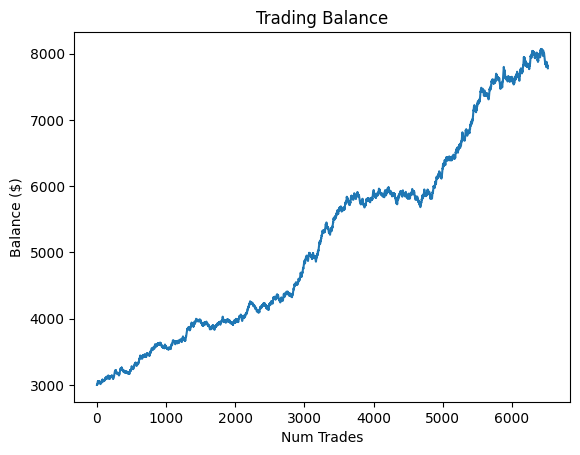

In [27]:
print('winning trades\t', win_count)
print('total trades\t', total)
print('winrate\t\t', win_count/total)
print('win streak\t', max_wins)
print('lose streak\t', max_losses)
print('min balance\t', min(balance))
print('final balance\t', balance[-1])

plt.figure()
plt.plot(balance)
plt.title('Trading Balance')
plt.xlabel('Num Trades')
plt.ylabel('Balance ($)')
plt.show()

## Final Word

### Using this strategy

Disclaimer: The results look too good to be true. That's because they are. Remember, this is paper trading, and a hack job at that. Actual fees and slippage will probably eat up all potential profit and all money you put toward day trading if you attempt to use this strategy for real. I am not responsible for your irresponsible choices!

### Refactoring

If I were to refactor this project, I would do something like this:

1. Define a data wrapper over the dataframe, which would iterate over the already marked data
2. Define a singleton TradeSpotter class which would ingest the iterated data from the wrapper, searching for trade openings. It would then keep a dictionary of ActiveTrades
3. Define an ActiveTrade class which stores relevant trade data (trade number, position, stop loss, take profit, price point data, etc). It stops collecting price point data once the stop loss or take profit is reached.
4. The instances of the TradeSpotter and ActiveTrade classes have a one-to-many publisher/subscriber relationship. TradeSpotter spawns a new ActiveTrade and appends it to its activeTrade dictionary, keyed by trade number. 
5. As the TradeSpotter ingests a new datum, that data is broadcast to the activeTrades, which then return a boolean deciding whether to stay subscribed, or unsubscribe.
6. Define an Aggregator that tracks and reports basic overall trade statistics. It could be implemented with a balance and other relavant variables to spoof paper trading
7. ActiveTrade instances are destroyed after passing their statistics to the Aggregator

Basically, I'd use OOP principles to break down the trading loop into digestible pieces. 

### Further Refactoring

If I wanted to go even further, for realtime data and persisting...

1. create a database, probably in postgreSQL.
2. read up on postgres' Listen/Notify protocol and create listeners to decouple parts of the project
3. connect to an API which sends minute-by-minute price action data and query it every minute
4. log the price action, which triggers an event to calculate the fractals and EMAs for the new minute
5. log the calculated values, which notifies the TradeSpotter, who keeps the same functionality as above
6. the ActiveTrade class becomes slimmer, as their birth/death timestamps are persisted in a table, and no longer eating up memory in execution
7. A separate project would replace the Aggregator altogether to analyze, visualize, and interact with the trade and raw price action data.